In [160]:
%matplotlib inline
import numpy as np
import math, random
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

class Landmark:
    def __init__(self,x,y):
        self.position = np.array([x,y])
        
    def __str__(self):
        return "(%f,%f)" % (self.position[0],self.position[1]) 
    
    def getX(self):
        return self.position[0]
    
    def getY(self):
        return self.position[1]
    
actual_landmarks = (Landmark(-0.5,0),Landmark(0.5,0),Landmark(0,0.5))

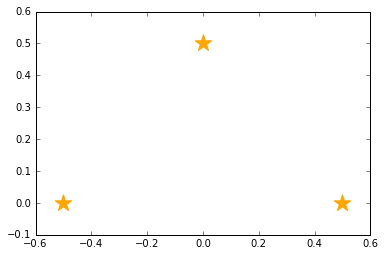

In [163]:
lxs = [e.getX() for e in actual_landmarks]
lys = [e.getY() for e in actual_landmarks]
plt.scatter(lxs,lys,s=300,marker="*",label="actual landmarks",color="orange")

In [176]:
class Gaussian2D:
    def __init__(self,sigma_x = 1.0, sigma_y = 1.0, cov_xy = 0.0,mu_x = 0.0, mu_y = 0.0):
        self.cov = np.array([[sigma_x,cov_xy],[cov_xy,sigma_y]])
        self.mean = np.array([mu_x,mu_y]).T
        
    def shift(self,delta,angle):
        ca = math.cos(angle)
        sa = math.sin(angle)
        rot = np.array([[ca,sa],[-sa,ca]])
        
        self.cov = rot.dot(self.cov).dot(rot.T)
        self.mean = self.mean + delta
        
    def value(self, pos):
        delta = pos - self.mean
        numerator = math.exp(-0.5 * (delta.T).dot(self.cov.I).dot(delta))
        denominator = 2 * math.pi * math.sqrt(np.linalg.det(self.cov))
        return numerator / denominator
    
    def ellipse(self):
        eigen = np.linalg.eig(self.cov)
        
        v1 = eigen[0][0] * eigen[1][0]
        v2 = eigen[0][1] * eigen[1][1]
        v1_direction = math.atan2(v1[1],v1[0])
        
        e = Ellipse(self.mean,width=np.linalg.norm(v1),height=np.linalg.norm(v2),angle=v1_direction/3.14*180)
        e.set_alpha(0.2)
        
        return e

In [194]:

class Robot:
    def __init__(self,x,y,rad):
        self.actual_poses = [np.array([x,y,rad])]
        self.guess_poses = [np.array([x,y,rad])]
        self.observed_landmarks = []
        random.seed()
        
        self.step = 0
        
        self.sensor_max_range = 1.0
        self.sensor_min_range = 0.1
        self.sensor_max_angle = math.pi / 2
        self.sensor_min_angle = - math.pi /2 
        
    def getGuessX(self):             return self.guess_poses[-1][0]
    def getGuessY(self):             return self.guess_poses[-1][1]
    def getGuessTheta(self):     return self.guess_poses[-1][2]
    
    def getActualXs(self):           return [e[0] for e in self.actual_poses]
    def getActualYs(self):           return [e[1] for e in self.actual_poses]
    def getActualThetas(self):   return [e[2] for e in self.actual_poses]
    def getActualDXs(self):           return [math.cos(e[2]) for e in self.actual_poses]
    def getActualDYs(self):           return [math.sin(e[2]) for e in self.actual_poses]
    
    def getGuessXs(self):           return [e[0] for e in self.guess_poses]
    def getGuessYs(self):           return [e[1] for e in self.guess_poses]
    def getGuessThetas(self):   return [e[2] for e in self.guess_poses]
    def getGuessDXs(self):   return [math.cos(e[2]) for e in self.guess_poses]
    def getGuessDYs(self):   return [math.sin(e[2]) for e in self.guess_poses]
    
    def getObservationXs(self): return [e["pos"][0] for e in self.observed_landmarks]
    def getObservationYs(self): return [e["pos"][1] for e in self.observed_landmarks]
    
    def printObservations(self):
        for e in self.observed_landmarks:
            print("step: %d, id: %d, measurement: (%f,%f), pos: (%f,%f)" %
                  (e["step"],e["id"],e["measurement"][0],e["measurement"][1],e["pos"][0],e["pos"][1]) )
    
    def move(self,fw,rot):
        self.step += 1
        
        actual_fw = random.gauss(fw,fw/10)    #10% noise
        actual_rot = random.gauss(rot,rot/10) #10% noise
        
        p = self.actual_poses[-1]
        px, py, pt = p[0],p[1],p[2]
        x = px + actual_fw * math.cos(pt)
        y = py + actual_fw * math.sin(pt)
        t = pt + actual_rot
        self.actual_poses.append(np.array([x,y,t]))
        
        g = self.guess_poses[-1]
        gx, gy, gt = g[0],g[1],g[2]
        x = gx + fw * math.cos(gt)
        y = gy + fw * math.sin(gt)
        t = gt + rot
        self.guess_poses.append(np.array([x,y,t]))
        
    def observe(self,landmarks):
        observed = []
        rx,ry,rt = self.getGuessX(),self.getGuessY(),self.getGuessTheta()
        for i,landmark in enumerate(landmarks):
            lx,ly = landmark.getX(),landmark.getY()
            distance = math.sqrt((rx-lx)**2 + (ry-ly)**2)
            if distance > self.sensor_max_range or distance < self.sensor_min_range:
                continue
                
            direction = math.atan2(ly-ry, lx-rx) - rt
            if direction > math.pi:    direction -= 2*math.pi
            if direction < -math.pi:   direction += 2*math.pi
            
            if direction > self.sensor_max_angle or direction < self.sensor_min_angle:
                continue
            
            #add noise
            distance = random.gauss(distance,distance/10)   #10% gauss noise
            direction = random.gauss(direction,math.pi * 10 /180)   #10deg gauss noise
            
            x = rx + distance * math.cos(rt + direction)
            y = ry + distance * math.sin(rt + direction)
            
            e = Gaussian2D(sigma_x = distance/10, sigma_y = distance * math.sin(math.pi * 10 /180 ) , 
                            cov_xy = 0.0)
            e.shift(np.array([x,y]).T, rt + direction)
            
            self.observed_landmarks.append( 
                {"step":self.step, "id":i, "measurement": (distance,direction),"ellipse":e}
            )
            
            

In [189]:
robot = Robot(0,0,0)

for i in range(20):
    robot.observe(actual_landmarks)
    robot.move(0.3,3.14/6)

[ 0.44384678 -0.03222822]
[ 0.05184163  0.42200375]
[ 0.52915395 -0.02583479]
[-0.03039784  0.47574809]
[ 0.12432232  0.62227523]
[-0.0542037   0.33691465]
[ 0.12219262  0.36637548]
[ 0.09049023  0.48361695]
[-0.01553192  0.59053322]
[-0.00679487  0.50650327]
[-0.55986908 -0.02037922]
[ 0.00586467  0.49612806]
[-0.52834387  0.0504937 ]
[ 0.48353157  0.01443531]
[-0.00911089  0.39434047]
[ 0.48000141  0.10866467]
[ 0.01953577  0.54097776]
[ 0.53874026  0.09636653]
[ 0.03359618  0.45652384]
[ 0.51182211  0.00228626]
[ 0.04756989  0.47060542]
[-0.00463936  0.36846941]


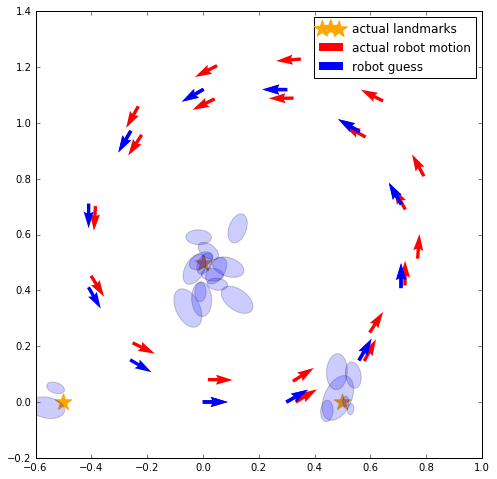

In [202]:
fig = plt.figure(0,figsize=(16, 8))
sp = fig.add_subplot(111, aspect='equal')

plt.scatter(lxs,lys,s=300,marker="*",label="actual landmarks",color="orange")
plt.quiver(robot.getActualXs(),robot.getActualYs(),robot.getActualDXs(),robot.getActualDYs(),
           color="red",label="actual robot motion")
plt.quiver(robot.getGuessXs(),robot.getGuessYs(),robot.getGuessDXs(),robot.getGuessDYs(),
           color="blue",label="robot guess")

for obs in robot.observed_landmarks:
    sp.add_artist(obs["ellipse"].ellipse())
    
#sp.set_xlim(-2, 2)
#sp.set_ylim(-1, 2)

#plt.scatter(robot.getObservationXs(),robot.getObservationYs(),s=100,marker="*",label="guess landmarks",color="red")
plt.legend()
plt.show()

In [ ]:
print(robot.observed_landmarks[0])

class GraphSlam2D:
    def __init__(self,robot):
        pass